# Part I: Classification

In [2]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import cross_val_score

df=pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv')
df.head(5)

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947
3,4,No,No,529.250605,35704.493935
4,5,No,No,785.655883,38463.495879


## 1) Load in the dataset
`https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [3]:
df = pd.read_csv("https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv")

In [4]:
df = df.drop(["Unnamed: 0"], axis = 1)

#### Verify the class imbalance

In [5]:
print("Samples per class (No): {}".format(sum(df["default"] == "No")))
print("Samples per class (Yes): {}".format(sum(df["default"] == "Yes")))

Samples per class (No): 9667
Samples per class (Yes): 333


** Class weight equal to balanced used for all models because the data is largely imbalanced. **

## 2) Convert `default` and `student` to categorical variables.

In [6]:
# Convert to binary
df["default"] = pd.Series(np.where(df["default"].values == 'Yes', 1, 0),
          df["default"].index)

In [7]:
# Convert to binary
df['student'] = pd.Series(np.where(df["student"].values == 'Yes', 1, 0),
          df["student"].index)

In [8]:
df = df.replace('No',0)
df = df.replace("Yes",1)
df.head(5)

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


## 3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color of the outcome of `default` labeled red if yes and blue if no. 

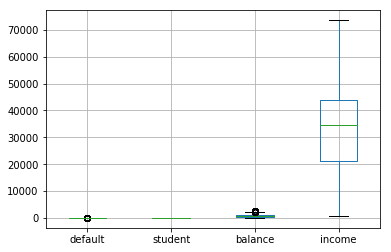

In [9]:
df.boxplot()
plt.show()

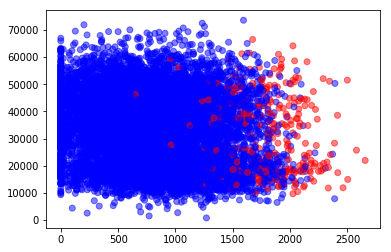

In [10]:
colors= df ["default"]
colors = colors.replace(1,"r").replace(0,"b")
plt.scatter(df['balance'],df['income'],c = colors, alpha=0.5)
plt.show()

## 4) 

Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley on the `balance` and `income` variables. 

Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

In [11]:
y = df.loc[:,"default"]
X = df.loc[:,["balance", "income"]]

In [12]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, random_state = 9598) #Splitting the data into Test and Train

In [13]:
lr = LogisticRegression(class_weight='balanced', penalty='l1').fit(X_train1,y_train1)
pred = lr.predict(X_test1)
print(roc_auc_score(y_test1, pred))

0.8706813191


In [14]:
sdf=df[df['student']==1] # should only be students
sdf.head(5)

,default,student,balance,income
1,0,1,817.180407,12106.134700
5,0,1,919.588530,7491.558572
7,0,1,808.667504,17600.451344
10,0,1,0.000000,21871.073089
11,0,1,1220.583753,13268.562221


#### Plot Decision Boundary

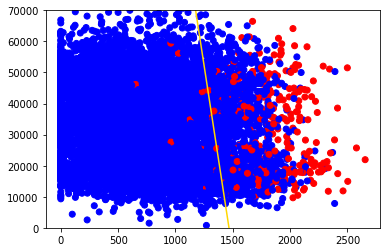

In [15]:
coef = lr.coef_
a = coef[0]
b = lr.intercept_
x = np.arange(0, 2600, 1)
y_plot = (b+a[0]*x)/-a[1]
plt.scatter(df['balance'],df['income'],c=colors)
plt.plot(x, y_plot, c = 'gold')
plt.ylim(0, 70000)
plt.show()

## 5) 
Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

In [252]:
X = df.loc[:,["balance", "income", "student"]]

In [260]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state = 9598) # Splitting the data into Test and Train

In [261]:
lr = LogisticRegression(class_weight='balanced', penalty = "l2").fit(X_train2, y_train2)
pred = lr.predict(X_test2)
print(roc_auc_score(y_test2, pred))

0.8753923908331784


Best alpha is 0.1


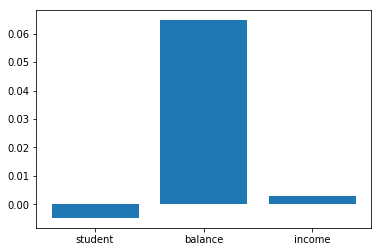

The coefficients are: [-0.00483573  0.06472572  0.00296429]


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
X = df[["student","balance","income"]]
y = df["default"]

scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

#X_scaled = preprocessing.scale(X)
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size = 0.2,random_state = 10)

# Construct alphas that we used in Ridge regularization
alphas = np.logspace(-5, -1, 1000)
scores = []

for alpha in alphas:
    regr = Ridge(alpha=alpha) # Ridge regularization definitaion
    regr.fit(X_train, y_train) # Fit tranning data
    scores.append((regr.score(X_test,y_test))) # Append score to the scores list

best_alpha = alphas[np.argmax(scores)]
print("Best alpha is %s" % best_alpha)

regr = Ridge(alpha = best_alpha)
regr.fit(X_train, y_train)

name_list = ['student','balance','income']  
fig = plt.figure()
plt.bar(range(len(regr.coef_)), regr.coef_, tick_label=name_list)    
plt.show()
print ('The coefficients are:',regr.coef_)

model = LogisticRegression(penalty='l1', C= best_alpha)
lreg = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

**There is a slight improvement in prediction but no significant increase.**

## 6) 

Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

** Stratified K Fold is used with shuffle = True ** 

In [262]:
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 9598)

In [263]:
scores = cross_val_score(LogisticRegression(class_weight='balanced', penalty = "l2"), 
                                             X_train2, 
                                             y_train2, scoring='roc_auc', cv = cv ) 
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores))) 

Mean cross-validation accuracy: 0.95


[ 0.97002997  0.97502498  0.97202797  0.972       0.971       0.974       0.97
  0.97497497  0.97797798  0.97197197]


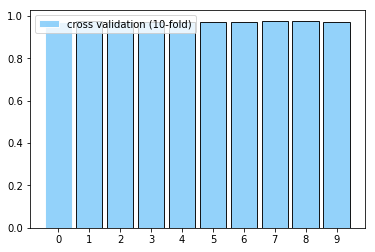

In [19]:
lcr = cross_val_score(lreg, X, y, cv=10)
print(lcr)

xr = np.arange(10)+1
name_list = range(10) 
fig = plt.figure()
plt.bar(xr, lcr, tick_label=name_list, alpha=0.9, width = 0.85, facecolor = 'lightskyblue', label='cross validation (10-fold)', edgecolor = 'white', lw=1)
plt.legend(loc="upper left") 
plt.show()

## 7) 
Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

#### Max_depth = 5

In [22]:
from sklearn import tree
import graphviz 

X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size = 0.2,random_state = 10)
clf = tree.DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

ModuleNotFoundError: No module named 'graphviz'

**Accuracy on cross-validated set falls compared to logistic with L2 penalty.**

In [23]:
# get decision tree
dt = DecisionTreeClassifier(class_weight = "balanced", max_depth = 5).fit(X_train2, y_train2)

# plot decision tree
dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data, feature_names=list(X_train2))  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

NameError: name 'X_train2' is not defined

#### Plot the decision tree

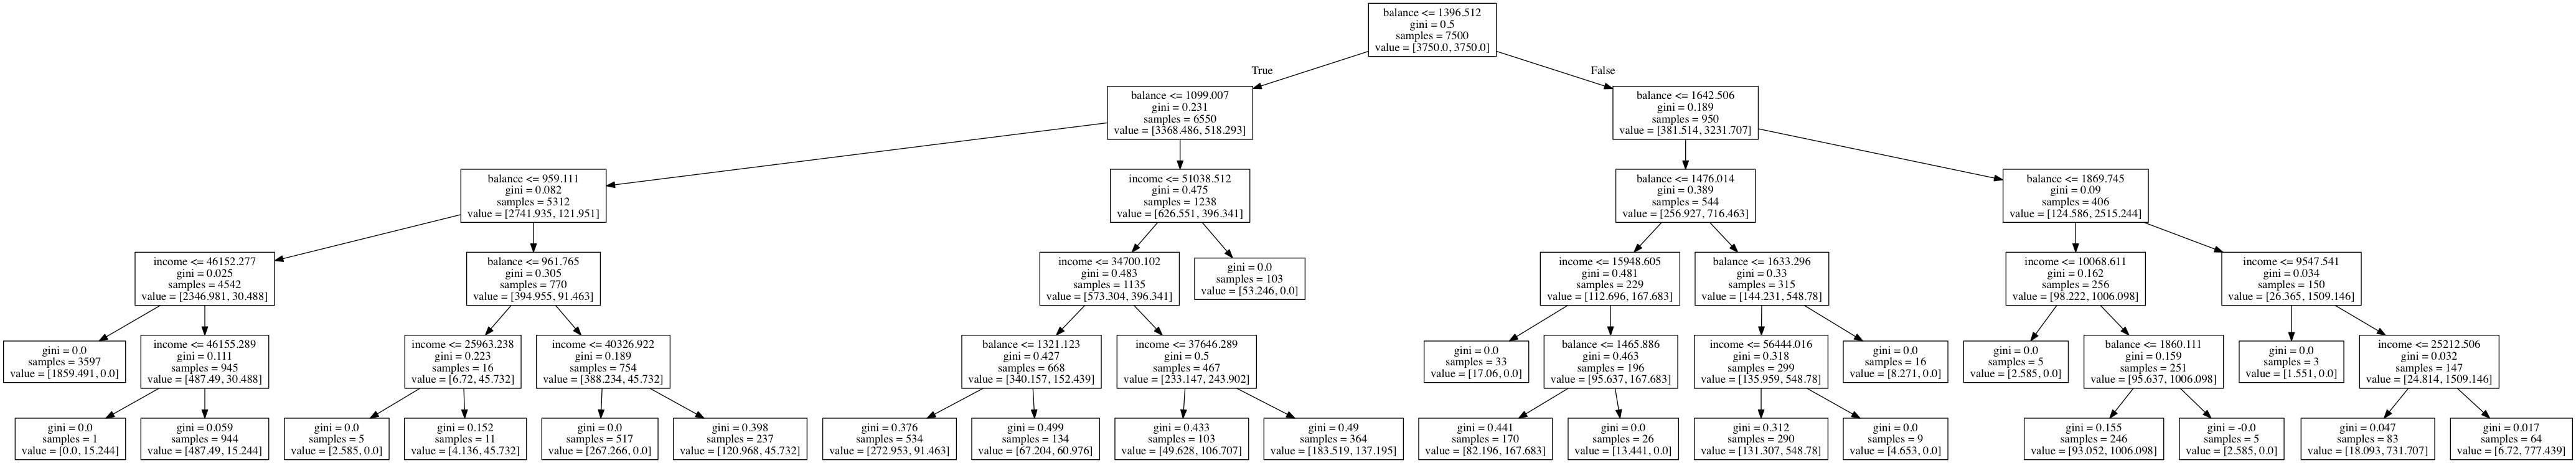

In [321]:
# get decision tree
dt = DecisionTreeClassifier(class_weight = "balanced", max_depth = 5).fit(X_train2, y_train2)

# plot decision tree
dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data, feature_names=list(X_train2))  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## 8) 
Find the optimal decision tree depth and compute the AUC ROC. 

The optimal depth is 3


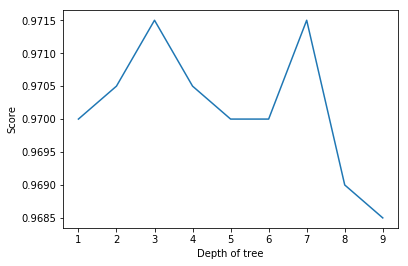

In [25]:
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,10)
for n in depths:
    d_tree = tree.DecisionTreeClassifier(max_depth=n)
    d_tree.fit(X_train, y_train)
    scores.append(d_tree.score(X_test,y_test))    

    
plt.ylabel('Score')
plt.xlabel('Depth of tree')
plt.plot(depths,scores)
test_errors = scores
optimal_depth = depths[np.argmax(scores)]
print('The optimal depth is %d' %(optimal_depth))
plt.show()

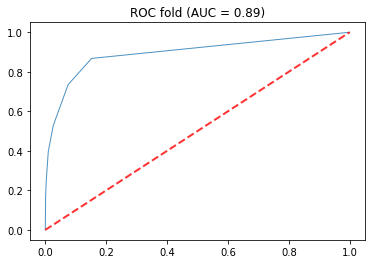

In [26]:
odt = tree.DecisionTreeClassifier(max_depth=optimal_depth)
odt.fit(X_train, y_train)
fpr, tpr, thresholds, roc_auc = get_auc(X_test,y_test,odt)
plt.plot(fpr, tpr, lw=1, alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.title('ROC fold (AUC = %0.2f)' % (roc_auc))
plt.show()

Accuracy on the test set: 0.89